[View in Colaboratory](https://colab.research.google.com/github/sungreong/TIL/blob/master/Explicit_Feedback_Neural_Recommender_Systems(Keras).ipynb)

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

Extracting ml-100k.zip to ml-100k...


https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/03_neural_recsys/Explicit_Feedback_Neural_Recommender_System.ipynb

In [2]:
!ls

datalab  ml-100k  ml-100k.zip


# Ratings file
 1. 유저
 2. 아이템 
 3. 1~5점까지 점수

In [3]:
import pandas as pd

raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# item metadata file


In [7]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8e54f9eb8>]],
      dtype=object)

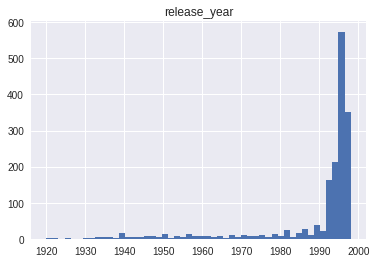

In [12]:
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    # Missing value marker
    return 1920


items["release_year"] = items["release_date"].map(extract_year)
items.hist("release_year", bins=50)

In [0]:
all_ratings = pd.merge(items, raw_ratings)

In [17]:
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


# DATA preprocessing
* 데이터를 잘 이해하기 위해

1. 유저의 수
2. 아이템의 수
3. 점수의 분포
4. 각각 영화의 유명도

In [18]:
max_user_id = all_ratings["user_id"].max()
print(max_user_id)
max_item_id = all_ratings["item_id"].max()
print(max_item_id)

943
1682


In [19]:
all_ratings["rating"].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [24]:
all_ratings.groupby("item_id").size().head()

item_id
1    452
2    131
3     90
4    209
5     86
dtype: int64

In [22]:
popularity = all_ratings.groupby("item_id").size().reset_index(name="popularity")
items = pd.merge(popularity , items)
items.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
1,2,131,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,1995
2,3,90,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,1995
3,4,209,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,1995
4,5,86,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),1995


In [23]:
items.nlargest(10,"popularity")

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year
49,50,583,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,1977
257,258,509,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),1997
99,100,508,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),1997
180,181,507,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,1997
293,294,485,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),1997
285,286,481,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,1996
287,288,478,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),1996
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
299,300,431,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,1997
120,121,429,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,1996


In [25]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,308,4,887736532
1,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,287,5,875334088
2,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,148,4,877019411
3,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,280,4,891700426
4,1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,66,3,883601324


In [0]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['rating']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['rating']

# 명쾌한 피드백 : 지도학습으로 가르친 ratings prediction

# regression problem

In [0]:
from tensorflow.contrib import keras
from keras.layers import Input, Embedding, Flatten, Dense, Dropout
from keras.layers import Dot
from keras.models import Model

In [0]:
user_id_input = Input(shape=[1], name="user")
item_id_input = Input(shape=[1], name="item")

embedding_size=30
user_embedding = Embedding(output_dim = embedding_size, input_dim = max_user_id + 1 , 
                          input_length=1, name="user_embedding")(user_id_input)

item_embedding = Embedding(output_dim = embedding_size, input_dim = max_item_id +1 , 
                         input_length=1 , name="item_embedding")(item_id_input)


# reshape (batch_size , input_length , embedding_size)
# to shape ( batch_size, input_length * embedding_size ) = (bath_size, embedding_size)

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

y= Dot(axes=1)([user_vecs, item_vecs])

model = Model(inputs=[user_id_input, item_id_input], outputs= y)
model.compile(optimizer="adam", loss="mae")

In [37]:

# Useful for debugging the output shape of model# Usefu 
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

(80000, 1)

# Model error
initial_train_preds 
* mean absolute error
* mean squared error

원래는 pandas series 를 numpy로 옮겨야 하지만 **rating_train.values** 를 사용하면 명쾌하게 이부분은 해결 된다.  
**object.shape**를 사용하여 각각의 shape를 계속 체크해야한다.

# Monitoring runs

keras 는 training 동안 다양한 변수가 잘되는지 감시 할 수 있다.  

history.history 는 mdel.fit 함수로 loss 를 포함한다. val_loss 는 validation_loss 이다 . 

In [39]:
%%time

history=model.fit([user_id_train, item_id_train], rating_train, batch_size=64 , epochs=10, validation_split=0.1, shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 6s 86us/step - loss: 2.9187 - val_loss: 1.3342
Epoch 2/10
72000/72000 [==============================] - 6s 87us/step - loss: 0.9659 - val_loss: 0.8323
Epoch 3/10
72000/72000 [==============================] - 6s 87us/step - loss: 0.7788 - val_loss: 0.7809
Epoch 4/10
25664/72000 [=========>....................] - ETA: 3s - loss: 0.7428

72000/72000 [==============================] - 6s 86us/step - loss: 0.7445 - val_loss: 0.7654
Epoch 5/10
72000/72000 [==============================] - 6s 86us/step - loss: 0.7297 - val_loss: 0.7570
Epoch 6/10
72000/72000 [==============================] - 6s 87us/step - loss: 0.7193 - val_loss: 0.7509
Epoch 7/10
68992/72000 [===========================>..] - ETA: 0s - loss: 0.7101

72000/72000 [==============================] - 6s 86us/step - loss: 0.7103 - val_loss: 0.7460
Epoch 8/10
72000/72000 [==============================] - 6s 87us/step - loss: 0.7015 - val_loss: 0.7466
Epoch 9/10
72000/72000 [==============================] - 6s 86us/step - loss: 0.6923 - val_loss: 0.7401
Epoch 10/10
72000/72000 [==============================] - 6s 86us/step - loss: 0.6837 - val_loss: 0.7378
CPU times: user 1min 13s, sys: 15.5 s, total: 1min 29s
Wall time: 1min 2s


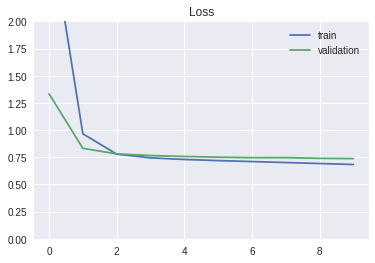

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');


## Questions? 
* 왜  처음 몇번의 epoch는 train loss가 더 높을까?
* 왜 케라스는 각각의 epoch 끝에 full training 에서의 training loss를 구하지 않을까?

In [43]:

from  sklearn.metrics  import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.915
Final test MAE: 0.733


In [44]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.787
Final train MAE: 0.668


위에선 fully conneted 에 대한 것을 구해봤다.

In [0]:
from keras.layers import Concatenate

In [0]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
model1 = Sequential()
model2 = Sequential()
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs])
## Error 1: Dropout was too high, preventing any training
input_vecs = Dropout(0.5)(input_vecs)

x = Dense(64, activation='relu')(input_vecs)

## Error 2: output dimension was 2 where we predict only 1-d rating
## Error 3: tanh activation squashes the outputs between -1 and 1
## when we want to predict values between 1 and 5
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)
## Error 4: A binary crossentropy loss is only useful for binary
## classification, while we are in regression (use mse or mae)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])

In [48]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=5, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/5
72000/72000 [==============================] - 9s 119us/step - loss: 1.0171 - val_loss: 0.7590
Epoch 2/5
72000/72000 [==============================] - 8s 116us/step - loss: 0.7541 - val_loss: 0.7443
Epoch 3/5
65088/72000 [==========================>...] - ETA: 0s - loss: 0.7374

72000/72000 [==============================] - 8s 114us/step - loss: 0.7383 - val_loss: 0.7389
Epoch 4/5
72000/72000 [==============================] - 8s 113us/step - loss: 0.7302 - val_loss: 0.7371
Epoch 5/5
72000/72000 [==============================] - 8s 114us/step - loss: 0.7239 - val_loss: 0.7313
CPU times: user 45.6 s, sys: 10.5 s, total: 56.1 s
Wall time: 41.9 s


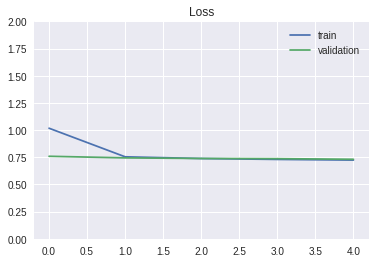

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [50]:

train_predstrain_p  = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

Final train MSE: 0.787
Final train MAE: 0.668


In [51]:

test_predstest_pr  = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.915
Final test MAE: 0.733


## Model Embeddings
* model.get_weights 를 이용하면 학습된 모든 파라미터를 가진 꺼내는 함수가 있다.
* 그 가중치는 모델이 만들어 질 때 같은 순서를 같은 순서로 가지게 된다.


In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 30)        28320       user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 30)        50490       item[0][0]                       
__________________________________________________________________________________________________
flatten_15

In [56]:
weights = model.get_weights()
[w.shape for w in weights]

[(944, 30), (1683, 30), (60, 64), (64,), (64, 1), (1,)]

In [59]:
user_embeddigs = weights[0]
item_embeddings = weights[1]

print("First item name from metadata:", items["title"][1])
print("Embedding vector for the first item:")
print(item_embeddings.shape)
print(item_embeddings[1])
print("shape:", item_embeddings[1].shape)


First item name from metadata: GoldenEye (1995)
Embedding vector for the first item:
(1683, 30)
[ 0.04050774  0.03935662 -0.03758998  0.04355044  0.0472622  -0.03672028
 -0.04318766  0.00511805  0.04097242 -0.00717903 -0.02099108 -0.03261201
 -0.04783171  0.01191078  0.03665877 -0.01705045  0.0115211   0.03722454
 -0.01838555  0.01369602 -0.02627811 -0.02252237 -0.02147919 -0.03340856
  0.01593249  0.03589339 -0.01124448 -0.02283057 -0.03143322  0.00840206]
shape: (30,)


# Finding most similar items

embedding space 안세 점에서 유사한 아이템 찾기

* 두 embedding space 간에 cosine similarity  계산한다.
* 다른 모든 좀들과 한 점의 embedding space 사이에서 유클리디안 거리를 계산한다.
* 가장 유사한 것을 적고 가장 작은  유클리디안 거리의 이름을 꺼내라
* 181 영화에서 찾아봐라 하지만 작은 데이터이니만큼 기적을 기대하면 안된다.


In [61]:
EPSILON = 1e-07

def cosine(x, y):
    dot_pdt = np.dot(x, y.T)
    norms = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_pdt / (norms + EPSILON)

# Computes cosine similarities between x and all item embeddings
def cosine_similarities(x):
    dot_pdts = np.dot(item_embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(item_embeddings, axis=1)
    return dot_pdts / (norms + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x):
    return np.linalg.norm(item_embeddings - x, axis=1)

# Computes top_n most similar items to an idx, 
def most_similar(idx, top_n=10, mode='euclidean'):
    sorted_indexes=0
    if mode == 'euclidean':
        dists = euclidean_distances(item_embeddings[idx])
        sorted_indexes = np.argsort(dists)
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["title"][idxs], dists[idxs]))
    else:
        sims = cosine_similarities(item_embeddings[idx])
        # [::-1] makes it possible to reverse the order of a numpy
        # array, this is required because most similar items have
        # a larger cosine similarity value
        sorted_indexes = np.argsort(sims)[::-1]
        idxs = sorted_indexes[0:top_n]
        return list(zip(items["title"][idxs], sims[idxs]))

# sanity checks:
print("cosine of item 1 and item 1: %0.3f"
      % cosine(item_embeddings[1], item_embeddings[1]))
euc_dists = euclidean_distances(item_embeddings[1])
print(euc_dists.shape)
print(euc_dists[1:5])
print()

# Test on movie 181: Return of the Jedi
print("Items closest to 'Return of the Jedi':")
for title, dist in most_similar(181, mode="euclidean"):
    print(title, dist)

cosine of item 1 and item 1: 1.000
(1683,)
[0.         0.25767443 0.25012448 0.23786435]

Items closest to 'Return of the Jedi':
GoodFellas (1990) 0.0
Perez Family, The (1995) 0.11275564
Hideaway (1995) 0.13089293
Cinema Paradiso (1988) 0.14112218
Spellbound (1945) 0.1478062
Apartment, The (1960) 0.14826405
U Turn (1997) 0.14833906
Living in Oblivion (1995) 0.14871171
Audrey Rose (1977) 0.14948075
Mad Dog Time (1996) 0.14973615


In [63]:
idx=181
print(item_embeddings[idx])
items["title"][idx]

[-0.00869782 -0.04885438  0.03753136 -0.02655383  0.02008405 -0.01855621
  0.01091     0.0301121  -0.00481547 -0.03102188  0.00494071  0.03479594
 -0.01549514  0.01009995 -0.03822652 -0.02761773  0.01701028 -0.02596815
  0.00984143  0.02013204 -0.03163414  0.00656409 -0.00246576 -0.00037147
 -0.04969611 -0.00153876  0.0279072   0.04681653  0.01553727 -0.00594928]


'GoodFellas (1990)'

# Visualizing embedding using TSNE


참고 : https://github.com/lmcinnes/umap

In [0]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=60).fit_transform(item_embeddings)

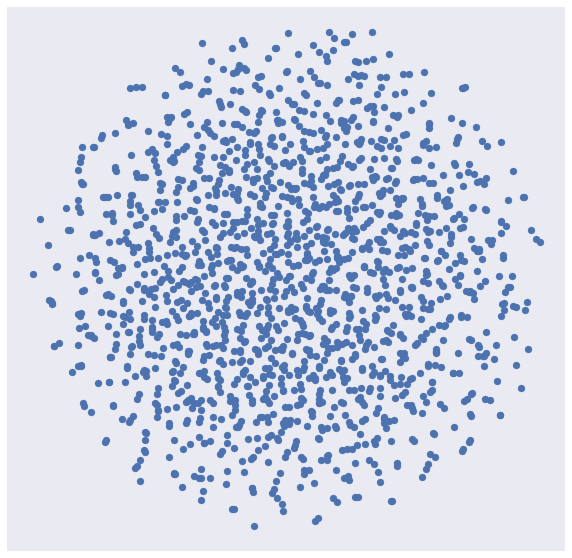

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [66]:
!pip install umap-learn

    100% |████████████████████████████████| 1.9MB 9.3MB/s 
    100% |████████████████████████████████| 15.8MB 2.5MB/s 
  Running setup.py bdist_wheel for umap-learn ... - done
  Stored in directory: /content/.cache/pip/wheels/3c/37/81/7d524766f1f6e20fdd5c113afd52b7006a0b01c985f2a43962
Successfully built umap-learn


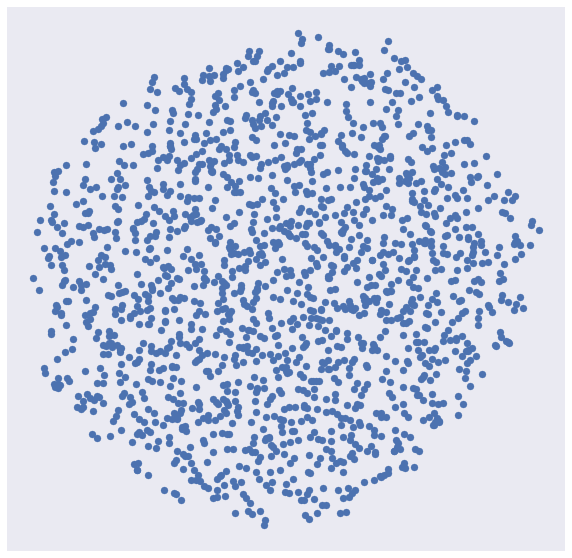

In [71]:
import umap

item_umap = umap.UMAP().fit_transform(item_embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(item_umap[:, 0], item_umap[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

# Using item metadata in the model 

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata.  
The resulting system is therefore an Hybrid Recommender System that does both Collaborative Filtering and Content-based recommendations.

In [0]:
from sklearn.preprocessing import QuantileTransformer

meta_columns = ['popularity', 'release_year']

scaler = QuantileTransformer()
item_meta_train = scaler.fit_transform(ratings_train[meta_columns])
item_meta_test = scaler.transform(ratings_test[meta_columns])

In [73]:
item_meta_train

array([[0.45245245, 0.46896897],
       [0.67417417, 0.71671672],
       [0.62912913, 0.34734735],
       ...,
       [0.86536537, 0.56556557],
       [0.61161161, 0.71671672],
       [0.56056056, 0.1006006 ]])

In [0]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[2], name='meta_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)


# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs, meta_input])

x = Dense(64, activation='relu')(input_vecs)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input, meta_input], outputs=y)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train, item_meta_train])

In [75]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train], rating_train,
                    batch_size=64, epochs=15, validation_split=0.1,
                    shuffle=True)

Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 10s 132us/step - loss: 0.9319 - val_loss: 0.7631
Epoch 2/15
72000/72000 [==============================] - 10s 133us/step - loss: 0.7604 - val_loss: 0.7427
Epoch 3/15
48320/72000 [===================>..........] - ETA: 2s - loss: 0.7390

72000/72000 [==============================] - 9s 130us/step - loss: 0.7396 - val_loss: 0.7362
Epoch 4/15
72000/72000 [==============================] - 9s 131us/step - loss: 0.7202 - val_loss: 0.7260
Epoch 5/15
72000/72000 [==============================] - 9s 130us/step - loss: 0.6982 - val_loss: 0.7227
Epoch 6/15
20800/72000 [=======>......................] - ETA: 6s - loss: 0.6824

72000/72000 [==============================] - 9s 131us/step - loss: 0.6839 - val_loss: 0.7235
Epoch 7/15
72000/72000 [==============================] - 9s 130us/step - loss: 0.6731 - val_loss: 0.7163
Epoch 8/15
72000/72000 [==============================] - 9s 132us/step - loss: 0.6629 - val_loss: 0.7129
Epoch 9/15
15680/72000 [=====>........................] - ETA: 7s - loss: 0.6561

72000/72000 [==============================] - 9s 131us/step - loss: 0.6548 - val_loss: 0.7126
Epoch 10/15
72000/72000 [==============================] - 9s 130us/step - loss: 0.6489 - val_loss: 0.7146
Epoch 11/15
72000/72000 [==============================] - 9s 131us/step - loss: 0.6425 - val_loss: 0.7154
Epoch 12/15
14272/72000 [====>.........................] - ETA: 7s - loss: 0.6241

72000/72000 [==============================] - 9s 131us/step - loss: 0.6385 - val_loss: 0.7150
Epoch 13/15
72000/72000 [==============================] - 9s 131us/step - loss: 0.6332 - val_loss: 0.7146
Epoch 14/15
72000/72000 [==============================] - 9s 130us/step - loss: 0.6285 - val_loss: 0.7136
Epoch 15/15
13952/72000 [====>.........................] - ETA: 7s - loss: 0.6193

72000/72000 [==============================] - 9s 130us/step - loss: 0.6242 - val_loss: 0.7075
CPU times: user 2min 36s, sys: 35 s, total: 3min 11s
Wall time: 2min 21s


In [76]:

test_predstest_pr  = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.915
Final test MAE: 0.733


## A recommendataion function for a given user 

사람들이 보지 못했던 것을 이제 우리는 학습된 모델로 할 수가 있다.

* model.predict  을 사용해서 to compute the ratings a user would have given to all items
*  recon function을 통해 본 것은 제외하고 보지 않은 것을 추천 할 수 있다.

In [77]:
indexed_items = items.set_index("item_id")

indexed_items.head()

,popularity,title,release_date,video_release_date,imdb_url,release_year
item_id,,,,,,
1,452,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
2,131,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,1995
3,90,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,1995
4,209,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,1995
5,86,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),1995


In [0]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    print("User %d has seen %d movies, including:" % (user_id, len(seen_movies)))
    for title in all_ratings[seen_mask].nlargest(20, 'popularity')['title']:
        print("   ", title)
    print("Computing ratings for %d other movies:" % len(item_ids))
    
    item_ids = np.array(item_ids)
    user_ids = np.zeros_like(item_ids)
    user_ids[:] = user_id
    items_meta = scaler.transform(indexed_items[meta_columns].loc[item_ids])
    
    rating_preds = model.predict([user_ids, item_ids, items_meta])
    
    item_ids = np.argsort(rating_preds[:, 0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["title"][movie], rating_preds[movie][0])
            for movie in rec_items]    

In [80]:
for title, pred_rating in recommend(10):
    print("    %0.1f: %s" % (pred_rating, title))

User 10 has seen 184 movies, including:
    Star Wars (1977)
    Fargo (1996)
    Liar Liar (1997)
    English Patient, The (1996)
    Toy Story (1995)
    Raiders of the Lost Ark (1981)
    Godfather, The (1972)
    Pulp Fiction (1994)
    Twelve Monkeys (1995)
    Silence of the Lambs, The (1991)
    Forrest Gump (1994)
    Monty Python and the Holy Grail (1974)
    Full Monty, The (1997)
    Terminator, The (1984)
    Dead Man Walking (1995)
    Leaving Las Vegas (1995)
    Braveheart (1995)
    L.A. Confidential (1997)
    Alien (1979)
    When Harry Met Sally... (1989)
Computing ratings for 1497 other movies:
    5.4: Cowboy Way, The (1994)
    5.2: Out to Sea (1997)
    5.1: Audrey Rose (1977)
    5.0: Next Karate Kid, The (1994)
    5.0: Shadow of Angels (Schatten der Engel) (1976)
    4.9: Smile Like Yours, A (1997)
    4.9: Of Love and Shadows (1994)
    4.9: Horse Whisperer, The (1998)
    4.8: Star Maps (1997)
    4.8: Frighteners, The (1996)


In [81]:
import numpy as np

np.unique(rating_train)

array([1, 2, 3, 4, 5])


Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

* setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
* optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

In [88]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 16
dense_size = 128
dropout_embedding = 0.5
dropout_hidden = 0.2

user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs])
input_vecs = Dropout(dropout_embedding)(input_vecs)

x = Dense(dense_size, activation='relu')(input_vecs)
x = Dropout(dropout_hidden)(x)
x = Dense(dense_size, activation='relu')(x)
y = Dense(5, activation='softmax')(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 16)        15104       user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 16)        26928       item[0][0]                       
__________________________________________________________________________________________________
flatten_25

In [83]:
initial_train_preds = model.predict([user_id_train, item_id_train]).argmax(axis=1) + 1
print("Random init MSE: %0.3f" % mean_squared_error(initial_train_preds, rating_train))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_train_preds, rating_train))


history = model.fit([user_id_train, item_id_train], rating_train - 1,
                    batch_size=64, epochs=15, validation_split=0.1,
                    shuffle=True)



Random init MSE: 4.750
Random init MAE: 1.804
Train on 72000 samples, validate on 8000 samples
Epoch 1/15
72000/72000 [==============================] - 10s 135us/step - loss: 1.3680 - val_loss: 1.2785
Epoch 2/15
72000/72000 [==============================] - 9s 130us/step - loss: 1.2837 - val_loss: 1.2592
Epoch 3/15
25088/72000 [=========>....................] - ETA: 5s - loss: 1.2587

72000/72000 [==============================] - 9s 130us/step - loss: 1.2609 - val_loss: 1.2539
Epoch 4/15
72000/72000 [==============================] - 9s 131us/step - loss: 1.2510 - val_loss: 1.2494
Epoch 5/15
72000/72000 [==============================] - 9s 131us/step - loss: 1.2446 - val_loss: 1.2448
Epoch 6/15
16832/72000 [======>.......................] - ETA: 7s - loss: 1.2287

72000/72000 [==============================] - 9s 132us/step - loss: 1.2362 - val_loss: 1.2483
Epoch 7/15
72000/72000 [==============================] - 9s 130us/step - loss: 1.2338 - val_loss: 1.2410
Epoch 8/15
72000/72000 [==============================] - 9s 129us/step - loss: 1.2282 - val_loss: 1.2439
Epoch 9/15
15424/72000 [=====>........................] - ETA: 7s - loss: 1.2142

72000/72000 [==============================] - 9s 131us/step - loss: 1.2250 - val_loss: 1.2403
Epoch 10/15
72000/72000 [==============================] - 9s 131us/step - loss: 1.2227 - val_loss: 1.2394
Epoch 11/15
72000/72000 [==============================] - 9s 130us/step - loss: 1.2201 - val_loss: 1.2395
Epoch 12/15
14400/72000 [=====>........................] - ETA: 7s - loss: 1.2057

72000/72000 [==============================] - 9s 129us/step - loss: 1.2161 - val_loss: 1.2410
Epoch 13/15
72000/72000 [==============================] - 9s 131us/step - loss: 1.2156 - val_loss: 1.2398
Epoch 14/15
72000/72000 [==============================] - 9s 130us/step - loss: 1.2142 - val_loss: 1.2412
Epoch 15/15
14464/72000 [=====>........................] - ETA: 7s - loss: 1.1995

72000/72000 [==============================] - 9s 131us/step - loss: 1.2137 - val_loss: 1.2394


In [94]:
rating_train.head() - 1

10382    3
73171    3
30938    3
99310    2
58959    4
Name: rating, dtype: int64

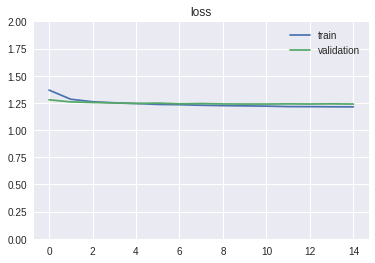

In [86]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('loss');



In [87]:
test_preds = model.predict([user_id_test, item_id_test]).argmax(axis=1) + 1
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 1.720
Final test MAE: 1.001
